# PPP + PPK Processing of EMLID Reach RS+ GPS data

**Script prepared by A. Rovere - MARUM, University of Bremen**

This script can be used to process data from two EMLID REACH RS+ GPS receivers (single band). One is a rover, the second is used as base station. Base station data are processed with PPP. To use the script, the following inputs are required:

 - Base station data processed with the National Resources Canada (NRCAN) Precise Point Positioning service (CSRS-PPP)
 - Rover data processed with RTKlib as kinematic points and saved as *.pos* file
 - Files exported from the data collector in *.csv* format

The script first merges the data collector files into a single dataframe. Then, postprocessed rover data is imported and a new dataframe is created with time-averaged postprocessed static positions acquired in FIX status. Time-averaged positions are also calculated for FLOAT status datapoints. All the results are saved in a multi-sheet excel file.

For a guide on how to use the NRCAN system and RTKlib with EMLID GPS, see:

https://docs.emlid.com/reach/common/tutorials/ppp-introduction/


This discussion on the EMLID forum contains some useful insights on the processing, as well another (similar) tool, including an intuitive user interface.

https://community.emlid.com/t/ppk-point-extractor-software/12822/46

## RTKlib setup
In RTKlib, remember to set up **output time in UTC**

For a guide on how to process your data with RTKlib, see:

https://docs.emlid.com/reach/common/tutorials/gps-post-processing/

A typical RTKlib configuration is annexed in the script main folder.

In [109]:
#Packages needed
import pandas as pd
import glob
import os
from pathlib import Path
import PyPDF2
import sys
import xlsxwriter as writer
import numpy as np
import os
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import utm
from matplotlib.patches import Ellipse
import math
from math import pi

## Input folders and data
For the script to work, it is necessary to indicate the folders where data are saved and some of the outputs from the NRCAN processing. See instructions below. 

In [110]:
#INSERT THE FOLLOWING VALUES
#Output file name
out='Example_output.xlsx'
#Insert the base station name
station_name = 'Camarones temporary base 11-12 November 2012' 
#Folder where CSV files from the data collector are stored
csv_folder = r'\Example_data\Rover\Data_collector'
#Folder where results of NRCAN processing are stored
Base_Report_folder = r'\Example_data\Base_station\NRCAN'
#Folder where pos files from RTKlib processing are stored and where the results will be saved
processed_data = r'\Example_data\Rover\Processed'

In [111]:
#DO NOT CHANGE VALUES HERE
dirname = os.path.realpath('')+processed_data
#Open the processed rover data ans extract base station position
processed_basepos = glob.glob(dirname + "/*.pos")
df = pd.read_csv(processed_basepos[0], header=None, skiprows=7,nrows=1)
basecoord=df.to_string()
basecoord=basecoord.replace('                                                      0\n0  % ref pos   :','')

## Input base Station data
Insert hereafter the requested results from NRCAN processing. These values can be found in the main report that is downloaded from the NRCAN CSRS-PPP service.

The processed base coordinates for **{{ station_name }}** are (lat/lon/ellipsoid height):

**{{ basecoord }}**

Open the NRCAN CSRS-PPP pdf report and copy the following values in the cell below. 

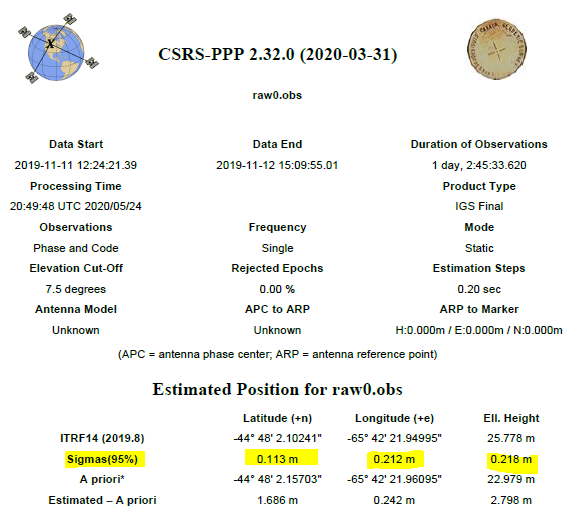


In [112]:
#INSERT THE FOLLOWING VALUES
#95% sigma Ellipsoid height
Hsigma = 0.218
#95% sigma Latitude
LATsigma = 0.113
#95% sigma Longitude
LONsigma = 0.212

In [113]:
#Extract first page of NRCAN report
dirname = os.path.realpath('')+Base_Report_folder
NRCANpdf = glob.glob(dirname + "/*.pdf")
pages = convert_from_path(NRCANpdf[0],
                          first_page=1,
                          last_page=1,
                         dpi=200)
for page in pages:
    page.save('out.jpg', 'JPEG')

#Write base station data to excel
#Open Excel workbook
writer = pd.ExcelWriter(out, engine='xlsxwriter',
                        options={'strings_to_numbers': True,
                                 'strings_to_formulas': False})
workbook=writer.book
wrap = workbook.add_format({'text_wrap': True, 
                            'valign':'vcenter',
                            'align':'center'})
# Insert essential data from the NRCAN report in the excel file
worksheet = workbook.add_worksheet('Base Station data')
worksheet.write('A1', 'Base Station data: '+station_name)
worksheet.insert_image('A3', 'out.jpg', {'x_scale': 0.5, 'y_scale': 0.5})

# Data collector files
Include in one folder all the *.csv* files exported from the data collector (Apple or Android) with ReachView software.

In [114]:
dirname = os.path.realpath('')+csv_folder
all_files = glob.glob(dirname + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['filename'] = os.path.basename(filename)
    li.append(df)
rawpoints = pd.concat(li, axis=0, ignore_index=True)
rawpoints['collection start'] = rawpoints['collection start'].astype('datetime64[ns]')
rawpoints['collection end'] = rawpoints['collection end'].astype('datetime64[ns]')
rawpoints.sort_values(by=['collection start'],inplace=True)
rawpoints.reset_index(inplace=True)
rawpoints.rename(columns={'name':'POINT ID',
                          'collection start':'Start of data collection (yyyy-mm-dd UTC)',
                         'collection end':'End of data collection (yyyy-mm-dd UTC)',
                         'sample count':'Total points sampled in the field',
                         'antenna height':'Rover Antenna height (m)'},inplace=True)
rawpoints.drop(columns=['level_0','index'],inplace=True)


rawpoints.to_excel(writer, sheet_name='Raw collector data', index=False)
worksheet = writer.sheets['Raw collector data']
worksheet.set_column('A:ZZ',20,wrap)
header_format = workbook.add_format({'bold': True,'text_wrap': True,'valign': 'vcenter','align':'center',
                                     'fg_color':'#C0C0C0','border': 1})
for col_num, value in enumerate(rawpoints.columns.values):
    worksheet.write(0, col_num, value, header_format)
rawpoints.drop(columns=['longitude','latitude','elevation','solution status','lateral rms'],inplace=True)

# Postprocessed GPS points
Include in one folder all the *.pos* data processed with RTKlib. The data need to be processed as "kinematic" points. For each point included in the data collector files, the script selects the corresponding processed points following the start and end timestamps. The script then calculates average and ±1sigma positions based on the postprocessed rover kinematic data. A further calculation of uncertainties incorporates the base station sigma values in the final uncertainties.

In [115]:
dirname = os.path.realpath('')+processed_data
all_files = glob.glob(dirname + "/*.pos")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,skiprows=10,delim_whitespace=True,parse_dates=[['%', 'UTC']])
    li.append(df)
processed = pd.concat(li, axis=0, ignore_index=True)
processed.reset_index(inplace=True)
processed['%_UTC'] = pd.to_datetime(processed['%_UTC'])

# Process points with a FIX solution available
processedQ1=processed.loc[processed['Q'] == 1]
dataQ1 = []
for index, row in rawpoints.iterrows():
    time_start=rawpoints['Start of data collection (yyyy-mm-dd UTC)'].values[index]
    time_end=rawpoints['End of data collection (yyyy-mm-dd UTC)'].values[index]
    processed_clip=processedQ1[(processedQ1['%_UTC'] >= time_start) & (processedQ1['%_UTC'] <=time_end)]
    row['Average postprocessed antenna Ellipsoid height (m)']=processed_clip['height(m)'].mean()
    row['Postprocessed Ellipsoid height ±1sigma (m)']=processed_clip['height(m)'].std()
    row['Average postprocessed latitude (degrees)']=processed_clip['latitude(deg)'].mean()
    row['Postprocessed latitude ±1sigma (degrees)']=processed_clip['latitude(deg)'].std()
    row['Average postprocessed longitude (degrees)']=processed_clip['longitude(deg)'].mean()
    row['Postprocessed Longitude ±1sigma (degrees)']=processed_clip['longitude(deg)'].std()
    row['Number of fix points processed']=processed_clip.loc[processed_clip.Q == 1, 'Q'].count()
    dataQ1.append(row)
dataQ1 = pd.DataFrame(dataQ1)
dataQ1 = dataQ1.dropna()
dataQ1['Ellipsoid heigh corrected for Rover antenna height (m)']=dataQ1['Average postprocessed antenna Ellipsoid height (m)']-dataQ1['Rover Antenna height (m)']
dataQ1['Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ1['Postprocessed Ellipsoid height ±1sigma (m)'])+np.square(float(Hsigma)/2))
dataQ1['Postprocessed Latitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ1['Postprocessed latitude ±1sigma (degrees)'])+np.square(float(LATsigma)/2))
dataQ1['Postprocessed Longitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ1['Postprocessed Longitude ±1sigma (degrees)'])+np.square(float(LONsigma)/2))

dataQ1 = dataQ1[['filename','POINT ID','Start of data collection (yyyy-mm-dd UTC)','End of data collection (yyyy-mm-dd UTC)',
                 'Total points sampled in the field','Number of fix points processed','Rover Antenna height (m)',
                 'Average postprocessed antenna Ellipsoid height (m)',
                 'Ellipsoid heigh corrected for Rover antenna height (m)','Postprocessed Ellipsoid height ±1sigma (m)',
                 'Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)',
                 'Average postprocessed latitude (degrees)','Postprocessed latitude ±1sigma (degrees)',
                 'Postprocessed Latitude including base uncertainty ±1sigma (m)',
                 'Average postprocessed longitude (degrees)','Postprocessed Longitude ±1sigma (degrees)',
                 'Postprocessed Longitude including base uncertainty ±1sigma (m)']]
#Write Q1 excel
if not dataQ1.empty:
    dataQ1.to_excel(writer, sheet_name='Postprocessed GPS points FIX', index=False)
    worksheet = writer.sheets['Postprocessed GPS points FIX']
    worksheet.set_column('A:ZZ',20,wrap)
    header_format = workbook.add_format({'bold': True,'text_wrap': True,'valign': 'vcenter','align':'center',
                                     'fg_color':'#C0C0C0','border': 1})
    for col_num, value in enumerate(dataQ1.columns.values):
        worksheet.write(0, col_num, value, header_format)

# Process points with a FLOAT solution available
processedQ2=processed.loc[processed['Q'] == 2]
dataQ2 = []
for index, row in rawpoints.iterrows():
    time_start=rawpoints['Start of data collection (yyyy-mm-dd UTC)'].values[index]
    time_end=rawpoints['End of data collection (yyyy-mm-dd UTC)'].values[index]
    processed_clip=processedQ2[(processedQ2['%_UTC'] >= time_start) & (processedQ2['%_UTC'] <=time_end)]
    row['Average postprocessed antenna Ellipsoid height (m)']=processed_clip['height(m)'].mean()
    row['Postprocessed Ellipsoid height ±1sigma (m)']=processed_clip['height(m)'].std()
    row['Average postprocessed latitude (degrees)']=processed_clip['latitude(deg)'].mean()
    row['Postprocessed latitude ±1sigma (degrees)']=processed_clip['latitude(deg)'].std()
    row['Average postprocessed longitude (degrees)']=processed_clip['longitude(deg)'].mean()
    row['Postprocessed Longitude ±1sigma (degrees)']=processed_clip['longitude(deg)'].std()
    row['Number of float points processed']=processed_clip.loc[processed_clip.Q == 2, 'Q'].count()
    dataQ2.append(row)
dataQ2 = pd.DataFrame(dataQ2)
dataQ2 = dataQ2.dropna()
dataQ2['Ellipsoid heigh corrected for Rover antenna height (m)']=dataQ2['Average postprocessed antenna Ellipsoid height (m)']-dataQ2['Rover Antenna height (m)']
dataQ2['Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ2['Postprocessed Ellipsoid height ±1sigma (m)'])+np.square(float(Hsigma)/2))
dataQ2['Postprocessed Latitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ2['Postprocessed latitude ±1sigma (degrees)'])+np.square(float(LATsigma)/2))
dataQ2['Postprocessed Longitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ2['Postprocessed Longitude ±1sigma (degrees)'])+np.square(float(LONsigma)/2))

dataQ2 = dataQ2[['filename','POINT ID','Start of data collection (yyyy-mm-dd UTC)','End of data collection (yyyy-mm-dd UTC)',
                 'Total points sampled in the field','Number of float points processed','Rover Antenna height (m)',
                 'Average postprocessed antenna Ellipsoid height (m)',
                 'Ellipsoid heigh corrected for Rover antenna height (m)','Postprocessed Ellipsoid height ±1sigma (m)',
                 'Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)',
                 'Average postprocessed latitude (degrees)','Postprocessed latitude ±1sigma (degrees)',
                 'Postprocessed Latitude including base uncertainty ±1sigma (m)',
                 'Average postprocessed longitude (degrees)','Postprocessed Longitude ±1sigma (degrees)',
                 'Postprocessed Longitude including base uncertainty ±1sigma (m)']]
#Write Q2 excel
if not dataQ2.empty:
    dataQ2.to_excel(writer, sheet_name='Postprocessed GPS points FLOAT', index=False)
    worksheet = writer.sheets['Postprocessed GPS points FLOAT']
    worksheet.set_column('A:ZZ',20,wrap)
    header_format = workbook.add_format({'bold': True,'text_wrap': True,
                                         'valign': 'vcenter','align':'center',
                                         'fg_color':'#C0C0C0','border': 1})
    for col_num, value in enumerate(dataQ2.columns.values):
        worksheet.write(0, col_num, value, header_format)

# Process points with a SBAS solution available
processedQ3=processed.loc[processed['Q'] == 3]
dataQ3 = []
for index, row in rawpoints.iterrows():
    time_start=rawpoints['Start of data collection (yyyy-mm-dd UTC)'].values[index]
    time_end=rawpoints['End of data collection (yyyy-mm-dd UTC)'].values[index]
    processed_clip=processedQ3[(processedQ3['%_UTC'] >= time_start) & (processedQ3['%_UTC'] <=time_end)]
    row['Average postprocessed antenna Ellipsoid height (m)']=processed_clip['height(m)'].mean()
    row['Postprocessed Ellipsoid height ±1sigma (m)']=processed_clip['height(m)'].std()
    row['Average postprocessed latitude (degrees)']=processed_clip['latitude(deg)'].mean()
    row['Postprocessed latitude ±1sigma (degrees)']=processed_clip['latitude(deg)'].std()
    row['Average postprocessed longitude (degrees)']=processed_clip['longitude(deg)'].mean()
    row['Postprocessed Longitude ±1sigma (degrees)']=processed_clip['longitude(deg)'].std()
    row['Number of sbas points processed']=processed_clip.loc[processed_clip.Q == 3, 'Q'].count()
    dataQ3.append(row)
dataQ3 = pd.DataFrame(dataQ3)
dataQ3 = dataQ3.dropna()
dataQ3['Ellipsoid heigh corrected for Rover antenna height (m)']=dataQ3['Average postprocessed antenna Ellipsoid height (m)']-dataQ3['Rover Antenna height (m)']
dataQ3['Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ3['Postprocessed Ellipsoid height ±1sigma (m)'])+np.square(float(Hsigma)/2))
dataQ3['Postprocessed Latitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ3['Postprocessed latitude ±1sigma (degrees)'])+np.square(float(LATsigma)/2))
dataQ3['Postprocessed Longitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ3['Postprocessed Longitude ±1sigma (degrees)'])+np.square(float(LONsigma)/2))

dataQ3 = dataQ3[['filename','POINT ID','Start of data collection (yyyy-mm-dd UTC)','End of data collection (yyyy-mm-dd UTC)',
                 'Total points sampled in the field','Number of sbas points processed','Rover Antenna height (m)',
                 'Average postprocessed antenna Ellipsoid height (m)',
                 'Ellipsoid heigh corrected for Rover antenna height (m)','Postprocessed Ellipsoid height ±1sigma (m)',
                 'Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)',
                 'Average postprocessed latitude (degrees)','Postprocessed latitude ±1sigma (degrees)',
                 'Postprocessed Latitude including base uncertainty ±1sigma (m)',
                 'Average postprocessed longitude (degrees)','Postprocessed Longitude ±1sigma (degrees)',
                 'Postprocessed Longitude including base uncertainty ±1sigma (m)']]
#Write Q3 excel
if not dataQ3.empty:
    dataQ3.to_excel(writer, sheet_name='Postprocessed GPS points SBAS', index=False)
    worksheet = writer.sheets['Postprocessed GPS points SBAS']
    worksheet.set_column('A:ZZ',20,wrap)
    header_format = workbook.add_format({'bold': True,'text_wrap': True,
                                         'valign': 'vcenter','align':'center',
                                         'fg_color':'#C0C0C0','border': 1})
    for col_num, value in enumerate(dataQ3.columns.values):
        worksheet.write(0, col_num, value, header_format)

# Process points with a SINGLE solution available
processedQ5=processed.loc[processed['Q'] == 5]
dataQ5 = []
for index, row in rawpoints.iterrows():
    time_start=rawpoints['Start of data collection (yyyy-mm-dd UTC)'].values[index]
    time_end=rawpoints['End of data collection (yyyy-mm-dd UTC)'].values[index]
    processed_clip=processedQ5[(processedQ5['%_UTC'] >= time_start) & (processedQ5['%_UTC'] <=time_end)]
    row['Average postprocessed antenna Ellipsoid height (m)']=processed_clip['height(m)'].mean()
    row['Postprocessed Ellipsoid height ±1sigma (m)']=processed_clip['height(m)'].std()
    row['Average postprocessed latitude (degrees)']=processed_clip['latitude(deg)'].mean()
    row['Postprocessed latitude ±1sigma (degrees)']=processed_clip['latitude(deg)'].std()
    row['Average postprocessed longitude (degrees)']=processed_clip['longitude(deg)'].mean()
    row['Postprocessed Longitude ±1sigma (degrees)']=processed_clip['longitude(deg)'].std()
    row['Number of single points processed']=processed_clip.loc[processed_clip.Q == 5, 'Q'].count()
    dataQ5.append(row)
dataQ5 = pd.DataFrame(dataQ5)
dataQ5 = dataQ5.dropna()
dataQ5['Ellipsoid heigh corrected for Rover antenna height (m)']=dataQ5['Average postprocessed antenna Ellipsoid height (m)']-dataQ5['Rover Antenna height (m)']
dataQ5['Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ5['Postprocessed Ellipsoid height ±1sigma (m)'])+np.square(float(Hsigma)/2))
dataQ5['Postprocessed Latitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ5['Postprocessed latitude ±1sigma (degrees)'])+np.square(float(LATsigma)/2))
dataQ5['Postprocessed Longitude including base uncertainty ±1sigma (m)']=np.sqrt(np.square(dataQ5['Postprocessed Longitude ±1sigma (degrees)'])+np.square(float(LONsigma)/2))

dataQ5 = dataQ5[['filename','POINT ID','Start of data collection (yyyy-mm-dd UTC)','End of data collection (yyyy-mm-dd UTC)',
                 'Total points sampled in the field','Number of single points processed','Rover Antenna height (m)',
                 'Average postprocessed antenna Ellipsoid height (m)',
                 'Ellipsoid heigh corrected for Rover antenna height (m)','Postprocessed Ellipsoid height ±1sigma (m)',
                 'Postprocessed Ellipsoid height including base uncertainty ±1sigma (m)',
                 'Average postprocessed latitude (degrees)','Postprocessed latitude ±1sigma (degrees)',
                 'Postprocessed Latitude including base uncertainty ±1sigma (m)',
                 'Average postprocessed longitude (degrees)','Postprocessed Longitude ±1sigma (degrees)',
                 'Postprocessed Longitude including base uncertainty ±1sigma (m)']]
#Write Q5 excel
if not dataQ5.empty:
    dataQ5.to_excel(writer, sheet_name='Postprocessed GPS points SINGLE', index=False)
    worksheet = writer.sheets['Postprocessed GPS points SINGLE']
    worksheet.set_column('A:ZZ',20,wrap)
    header_format = workbook.add_format({'bold': True,'text_wrap': True,
                                         'valign': 'vcenter','align':'center',
                                         'fg_color':'#C0C0C0','border': 1})
    for col_num, value in enumerate(dataQ5.columns.values):
        worksheet.write(0, col_num, value, header_format)        
        
workbook.close()

## Description of outputs
The output of this script is an excel file (*Processed data.xslx*) containing different sheets.
 - **Raw collector data.** These are the data downloaded from the collector, with minimal adustments on column names
 - **Base station data.** A summary of the NRCAN postprocessing results.
 - **Postprocessed GPS points FIX/FLOAT/SBAS/SINGLE.** Postprocessed FIX, FLOAT SBAS or SINGLE points organized in different sheets.
 
#### Legend for Postprocessed GPS points

***filename:*** The original data collector *csv* file.

***POINT ID:*** Original point ID as assigned during data collection. 

***Start of data collection (yyyy-mm-dd UTC):*** Start of raw data collection.

***End of data collection (yyyy-mm-dd UTC):*** End of raw data collection.

***Total points sampled in the field:*** Total points sampled during the survey in static mode.

***Number of fix points processed:*** Total points processed, concurring to the average calculations.

***Rover Antenna height (m):*** Rover antenna height as assigned originally in the field.

***Average postprocessed antenna Ellipsoid height (m):*** Average of postprocessed ellipsoid heights.

***Ellipsoid heigh corrected for Rover antenna height (m):*** Average of postprocessed ellipsoid heights corrected for antenna height. **Use this value as final elevation.** 

***Postprocessed Ellipsoid height ±1sigma (m):*** Standard deviation of postprocessed ellipsoid heights.

***Postprocessed Ellipsoid height including base uncertainty ±1sigma (m):*** Standard deviation of postprocessed ellipsoid heights, including uncertainty propagated in root mean square from the base processing. **Use this value as final elevation uncertainty.**

***Average postprocessed latitude (degrees):*** Average of postprocessed latitude corrected for antenna height. **Use this value as final latitude.** 

***Postprocessed latitude ±1sigma (degrees):*** Standard deviation of postprocessed latitude values.

***Postprocessed Latitude including base uncertainty ±1sigma (m):*** Standard deviation of postprocessed latitude values, including uncertainty propagated in root mean square from the base processing. **Use this value as final latitude uncertainty.**

***Average postprocessed longitude (degrees):*** Average of postprocessed longitude corrected for antenna height. **Use this value as final longitude.** 

***Postprocessed longitude ±1sigma (degrees):*** Standard deviation of postprocessed longitude values.

***Postprocessed longitude including base uncertainty ±1sigma (m):*** Standard deviation of postprocessed longitude values, including uncertainty propagated in root mean square from the base processing. **Use this value as final longitude uncertainty.**

## Accuracy of processing results
### Possible deviations from points processed as "Static" in RTKlib
The results included in the output spreadsheet are averages of several points acquired in static mode, but processed as kinematic in RTKlib. The results differ slightly if the same points are instead processed one by one as static points in RTKlib, which gives as a result a single point with uncertainties. This difference may vary according to survey conditions and occupation time. Here, we show an example based on a point surveyed in the town of Camarones, Argentina, in November 2019, for which fix postprocessed positions were obtained. The point was surveyed for 2 minutes.

In [116]:
#Insert data here
#Kinematic Postprocessing results
Lat=-44.79934606
Lat_unc=0.0565
Lon=-65.72829643
Lon_unc=0.106
Ellips_corr_height=48.36738453
Postpr_unc_1s=0.109007712

#Static Postprocessing results
Lat_static=-44.799345936
Lon_static=-65.728296743
Lat_static_1s=0.0002 #1-sigma from RTKlib postprocessing
Lon_static_1s=0.0001 #1-sigma from RTKlib postprocessing
Base_lat_2s=0.113 #2-sigma from NRCAN processing
Base_lon_2s=0.212 #2-sigma from NRCAN processing
Ellips_h_static=50.0803 #Ellipsoid height
Rover_ant_height=1.775 #Rover antenna height
Base_static_1s=0.0003 #1-sigma from RTKlib postprocessing
Base_H_2s=0.218 #2-sigma from NRCAN processing

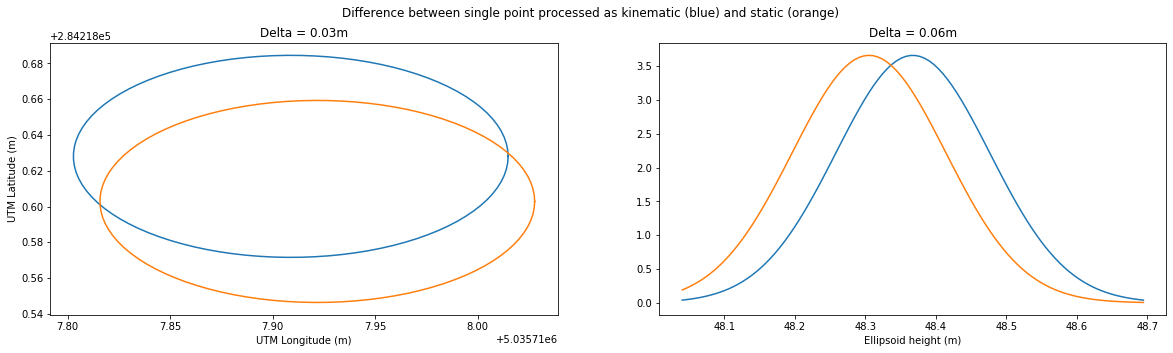

In [117]:
utm_kinematic = utm.from_latlon(Lat,Lon)
Lat=utm_kinematic[0]
Lon=utm_kinematic[1]

Lat_unc_static=np.sqrt(np.square(Lat_static_1s)+np.square(Base_lat_2s/2))
Lon_unc_static=np.sqrt(np.square(Lon_static_1s)+np.square(Base_lon_2s/2))
utm_static = utm.from_latlon(Lat_static,Lon_static)
Lat_static=utm_static[0]
Lon_static=utm_static[1]
Ellips_corr_height_static=(Ellips_h_static-Rover_ant_height)
Postpr_unc_1s_static=np.sqrt(np.square(Base_static_1s)+np.square(Base_H_2s/2))

fig, (ax2, ax1) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('Difference between single point processed as kinematic (blue) and static (orange)')
x = np.linspace(Ellips_corr_height - 3*Postpr_unc_1s, Ellips_corr_height + 3*Postpr_unc_1s, 100)
ax1.plot(x, stats.norm.pdf(x, Ellips_corr_height, Postpr_unc_1s))
ax1.plot(x, stats.norm.pdf(x, Ellips_corr_height_static, Postpr_unc_1s_static))
diff=abs(Ellips_corr_height_static-Ellips_corr_height)
ax1.set(xlabel='Ellipsoid height (m)', title='Delta = {:.2f}m'.format(diff))

f = np.linspace(0, 2*pi, 100)
ax2.plot(Lon+Lon_unc*np.cos(f) , Lat+Lat_unc*np.sin(f))
ax2.plot(Lon_static+Lon_unc_static*np.cos(f) , Lat_static+Lat_unc_static*np.sin(f))
dist = math.hypot(Lon_static - Lon, Lat_static - Lat)
ax2.set(xlabel='UTM Longitude (m)',ylabel='UTM Latitude (m)',title='Delta = {:.2f}m'.format(dist))

plt.show()

### Difference between FIX and FLOAT point
A second, more obvious difference, emerges when the same point is processed in FIX vs FLOAT point. The example belows is again extracted from a survey in Camarones, Argentina. Within the survey, 137 points were processed as float, and 469 as fix. The differences are shown hereafter. A FIX solution is always more reliable than a FLOAT one.

In [118]:
#Insert data here
#fix Postprocessing results
Lat=-44.80627032
Lat_unc=0.0565
Lon=-65.73385766
Lon_unc=0.106
Ellips_corr_height=23.40556269
Postpr_unc_1s=0.10939338

#float Postprocessing results
Lat_float=-44.8062775
Lat_unc_float=0.0565
Lon_float=-65.73383128
Lon_unc_float=0.106
Ellips_corr_height_float=24.3868781
Postpr_unc_1s_float=0.109187853

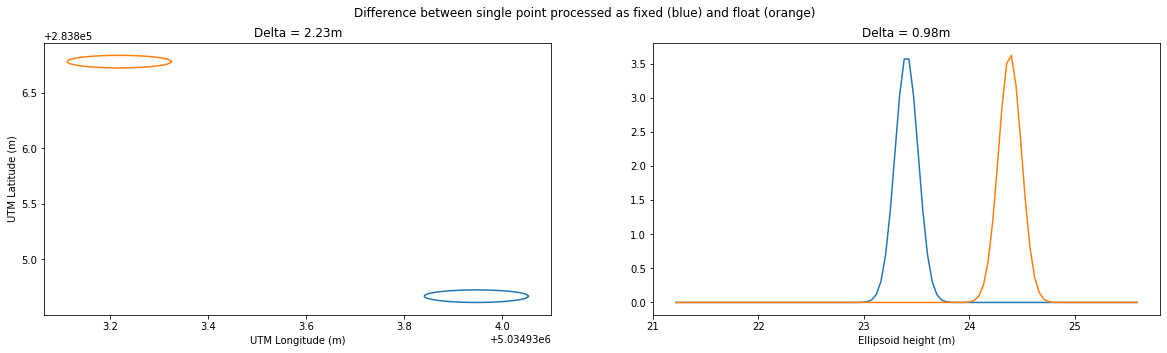

In [119]:
utm_kinematic = utm.from_latlon(Lat,Lon)
Lat=utm_kinematic[0]
Lon=utm_kinematic[1]

utm_float = utm.from_latlon(Lat_float,Lon_float)
Lat_float=utm_float[0]
Lon_float=utm_float[1]

fig, (ax2, ax1) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('Difference between single point processed as fixed (blue) and float (orange)')
x = np.linspace(Ellips_corr_height - 20*Postpr_unc_1s, Ellips_corr_height + 20*Postpr_unc_1s, 100)
ax1.plot(x, stats.norm.pdf(x, Ellips_corr_height, Postpr_unc_1s))
ax1.plot(x, stats.norm.pdf(x, Ellips_corr_height_float, Postpr_unc_1s_float))
diff=abs(Ellips_corr_height_float-Ellips_corr_height)
ax1.set(xlabel='Ellipsoid height (m)', title='Delta = {:.2f}m'.format(diff))

f = np.linspace(0, 2*pi, 100)
ax2.plot(Lon+Lon_unc*np.cos(f) , Lat+Lat_unc*np.sin(f))
ax2.plot(Lon_float+Lon_unc_float*np.cos(f) , Lat_float+Lat_unc_float*np.sin(f))
dist = math.hypot(Lon_float - Lon, Lat_float - Lat)
ax2.set(xlabel='UTM Longitude (m)',ylabel='UTM Latitude (m)',title='Delta = {:.2f}m'.format(dist))

plt.show()

### Absolute accuracy
The absolute accuracy can be gauged by comparing the processed point with a point of known coordinates. Hereafter, we compare the location of one point suveyed as static for 20 minutes (and processed with this script) with the coordinates of an official geodetic point (Point GPS 35 - Camarones).

In [120]:
#Benchmark location
Lat='44-47-48.18249S'
Lon='65-43-17.08927W'
Ellips_height=59.2191

#Postprocessing results
Lat_fix=-44.79671438
Lat_unc_fix=0.0565
Lon_fix=-65.72141542
Lon_unc_fix=0.106
Ellips_corr_height_fix=59.13916817
Postpr_unc_1s_fix=0.109064711

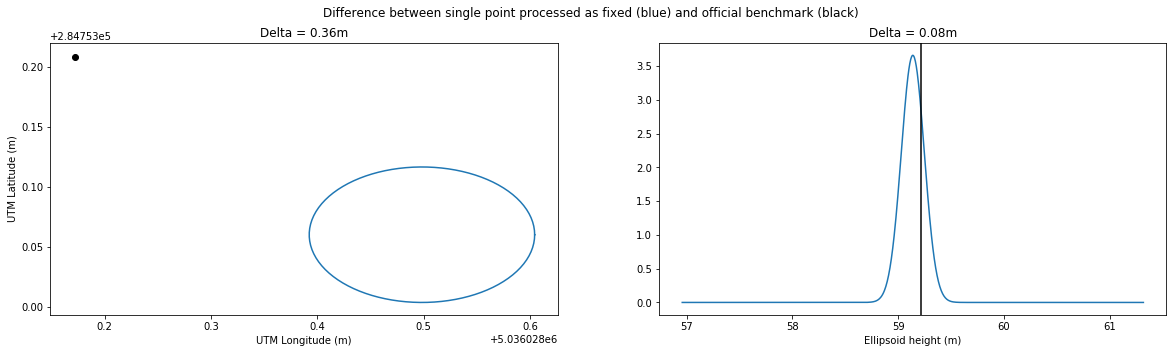

In [121]:
def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))

#Benchmark location
Lat=convert(Lat)
Lon=convert(Lon)
utm_bench = utm.from_latlon(Lat,Lon)
Lat=utm_bench[0]
Lon=utm_bench[1]

utm_fix = utm.from_latlon(Lat_fix,Lon_fix)
Lat_fix=utm_fix[0]
Lon_fix=utm_fix[1]

fig, (ax2, ax1) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('Difference between single point processed as fixed (blue) and official benchmark (black)')
x = np.linspace(Ellips_corr_height_fix - 20*Postpr_unc_1s_fix, Ellips_corr_height_fix + 20*Postpr_unc_1s_fix, 1000)
ax1.plot(x, stats.norm.pdf(x, Ellips_corr_height_fix, Postpr_unc_1s_fix))
ax1.axvline(x=Ellips_height, color='k', linewidth=1.5)
diff=abs(Ellips_corr_height_fix-Ellips_height)
ax1.set(xlabel='Ellipsoid height (m)', title='Delta = {:.2f}m'.format(diff))

f = np.linspace(0, 2*pi, 100)
ax2.plot(Lon_fix+Lon_unc_fix*np.cos(f) , Lat_fix+Lat_unc_fix*np.sin(f))
ax2.scatter(Lon,Lat,color='k')

dist = math.hypot(Lon_fix - Lon, Lat_fix - Lat)
ax2.set(xlabel='UTM Longitude (m)',ylabel='UTM Latitude (m)',title='Delta = {:.2f}m'.format(dist))

plt.show()

***
## License
This software is relased under the MIT license.

Copyright 2020 Alessio Rovere

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
***
# Research funding acknowledgments
This script and associated data were created in the framework of the European Reasearch Council Starting Grant WARMCOASTS (Grant Agreement Number 802414), funded under the European Union's Horizon 2020 research and Innovation programme.
***
# How to cite
Citation ref here
***
# Code acknowledgments
https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f
https://kite.com/python/answers/how-to-redirect-print-output-to-a-text-file-in-python
https://stackoverflow.com/questions/41857659/python-pandas-add-filename-column-csv
https://stackoverflow.com/questions/46184239/extract-a-page-from-a-pdf-as-a-jpeg
https://stackoverflow.com/questions/48531843/how-to-remove-rows-of-a-dataframe-based-off-of-data-from-another-dataframe
https://medium.com/better-programming/how-to-convert-latitude-longitude-to-distance-utm-and-geojson-34c982cda40
https://stackoverflow.com/questions/21298772/how-to-convert-latitude-longitude-to-decimal-in-python